In [8]:
import keras
from keras.applications import VGG16
from keras import backend as K 
import numpy as np

In [3]:
model = VGG16(weights='imagenet', 
             include_top = False)

In [3]:
layer_name = 'block3_conv1' #layer with the filter to 
filter_index = 0 #select the first filter 

In [4]:
layer_output = model.get_layer(layer_name).output #grab the output 

In [5]:
layer_output #just testing the shape of the output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>

In [6]:
K

<module 'keras.backend' from '/home/local/ASUAD/ppaudyal/anaconda3/envs/tf3/lib/python3.6/site-packages/keras/backend/__init__.py'>

In [7]:
loss = K.mean(layer_output[:,:,:,filter_index])

In [8]:
help(K.mean)

Help on function mean in module keras.backend.tensorflow_backend:

mean(x, axis=None, keepdims=False)
    Mean of a tensor, alongside the specified axis.
    
    # Arguments
        x: A tensor or variable.
        axis: An integer or list of integers in [-rank(x), rank(x)),
            the axes to compute the mean. If `None` (default), computes
            the mean over all dimensions.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1 for each entry in `axis`. If `keepdims` is `True`,
            the reduced dimensions are retained with length 1.
    
    # Returns
        A tensor with the mean of elements of `x`.



In [9]:
grads = K.gradients(loss, model.input)[0]

In [10]:
#gradient normalization trick 
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) 

In [11]:
grads

<tf.Tensor 'truediv:0' shape=(?, ?, ?, 3) dtype=float32>

In [12]:
model.input

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [13]:
iterate = K.function([model.input], [loss, grads])

In [14]:
iterate

In [17]:
import numpy as np 
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [18]:
loss_value

0.0

In [20]:
grads_value.shape

(1, 150, 150, 3)

In [22]:
#now define a python loop to do stocahastic gradient descent 
input_img_data = np.random.random((1, 150, 150, 3)) *20 +128

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.imshow(input_img_data.reshape(150, 150, 3)/255) #if you don't use 255, then it clips, and all is white

In [30]:
step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    print(loss_value)
    input_img_data += grads_value* step

4913.5723
5023.7554
5133.783
5243.537
5352.951
5462.0815
5571.1343
5679.9253
5788.421
5896.8916
6005.1006
6113.1816
6221.174
6328.981
6436.757
6544.344
6651.789
6759.202
6866.4644
6973.737
7080.825
7187.8203
7294.7173
7401.5376
7508.2534
7614.9546
7721.611
7828.1196
7934.5903
8041.034
8147.4814
8253.959
8360.369
8466.71
8572.9
8679.17
8785.33
8891.515
8997.693
9103.781


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


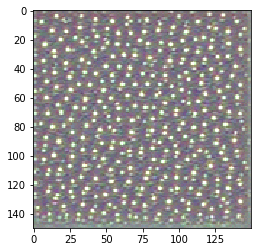

In [29]:
plt.imshow(input_img_data.reshape(150, 150, 3)/255)

In [5]:
#matplotlib complains that the above image is not in range, which means that some clipping took place 
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5) #normalize the tensor: centers on 0, ensures that std is 0.1
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
#now to generate clips for all filters 
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index]) 
    grads = K.gradients(loss, model.input)[0] #computes the gradient of the input picture with regard to the loss
    grads /= (K.sqrt(K.mean(K.square(grads)))) #normalization trick
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128 #starts with a gray image with some noise
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value* step
    img = input_img_data[0]
    return deprocess_image(img)

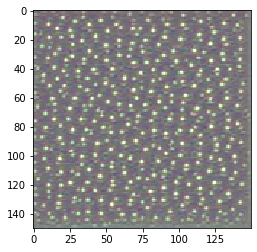

In [34]:
plt.imshow(generate_pattern('block3_conv1', 0))

Generating a grid of all filter response patterns in a layer 

<Figure size 432x288 with 0 Axes>

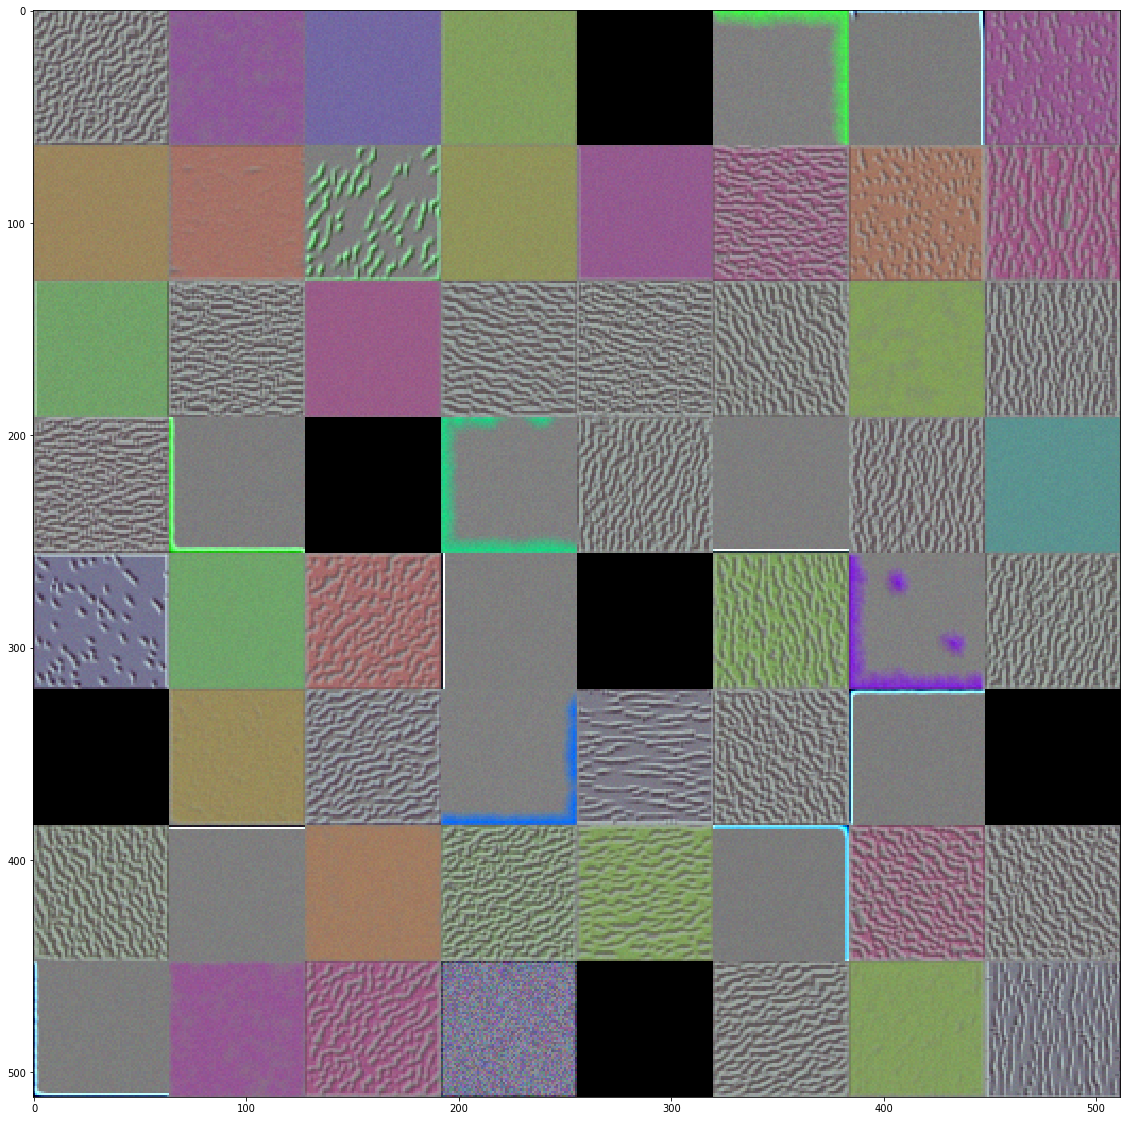

In [19]:
layer_name = 'block1_conv1' #iterate over in practice 
size = 64
margin = 5 #configurable 
plt.clf()
results = np.ones((8*size, 8*size, 3))
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+j*8
                                      , size=size)
        #plt.figure()
        
        horizontal_start = i * size  
        horizontal_end = horizontal_start + size 
        vertical_start = j * size 
        vertical_end = vertical_start + size 
#         print('Horizontal start: end', horizontal_start, horizontal_end)
#         print('Vertical start:end', vertical_start, vertical_end)
#         print('Image shape', filter_img.shape)
#         print('Results shape', results.shape)
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = generate_pattern(layer_name, i+j*8
                                      , size=size)
        #plt.imshow(results[horizontal_start: horizontal_end, vertical_start:vertical_end, :])
        #k = results[horizontal_start: horizontal_end, vertical_start:vertical_end, :]
        #print('k:', k.shape)
        #plt.imshow(k)
        #break
    #break
plt.figure(figsize=(20,20))
plt.imshow(results/255)

In [15]:
plt.figure()
plt.imshow(generate_pattern('block_conv1', 0, 64))

array([[52338., 60321., 58164.],
       [54840., 65877., 62266.],
       [54318., 58378., 56082.],
       ...,
       [58439., 53357., 57252.],
       [64691., 64194., 68389.],
       [52105., 51940., 58332.]])

In [49]:
model.layers

In [1]:
model

NameError: name 'model' is not defined